In [263]:
import pandas as pd #the csv reading library
import matplotlib.pyplot as plt #the ploting library
import glob #to get file names
import scipy.optimize
from scipy.optimize import curve_fit
from scipy import interpolate
from scipy.interpolate import pchip_interpolate
import numpy as np
import math
from pandas import Series
from lmfit import Model, Parameter, report_fit

In [264]:
# This returns a list of names (strings) of files that have the .txt extension. 
# You should provide the path
files = glob.glob('../../../CDOM_DATA/BLU22/BC_ABS_BLU22_2226_GB/*.txt')
files

['../../../CDOM_DATA/BLU22/BC_ABS_BLU22_2226_GB\\222601_Absorbance__0__00.txt',
 '../../../CDOM_DATA/BLU22/BC_ABS_BLU22_2226_GB\\222601_Absorbance__1__01.txt',
 '../../../CDOM_DATA/BLU22/BC_ABS_BLU22_2226_GB\\222602_Absorbance__0__02.txt',
 '../../../CDOM_DATA/BLU22/BC_ABS_BLU22_2226_GB\\222603_Absorbance__0__03.txt',
 '../../../CDOM_DATA/BLU22/BC_ABS_BLU22_2226_GB\\222604_Absorbance__0__04.txt',
 '../../../CDOM_DATA/BLU22/BC_ABS_BLU22_2226_GB\\222605_Absorbance__0__05.txt',
 '../../../CDOM_DATA/BLU22/BC_ABS_BLU22_2226_GB\\222606_Absorbance__0__06.txt',
 '../../../CDOM_DATA/BLU22/BC_ABS_BLU22_2226_GB\\222607_Absorbance__0__07.txt',
 '../../../CDOM_DATA/BLU22/BC_ABS_BLU22_2226_GB\\222607_Absorbance__0__08.txt',
 '../../../CDOM_DATA/BLU22/BC_ABS_BLU22_2226_GB\\222607_Absorbance__1__09.txt',
 '../../../CDOM_DATA/BLU22/BC_ABS_BLU22_2226_GB\\222607_Absorbance__2__10.txt',
 '../../../CDOM_DATA/BLU22/BC_ABS_BLU22_2226_GB\\222608_Absorbance__0__11.txt',
 '../../../CDOM_DATA/BLU22/BC_ABS_BLU22_

In [265]:
#first Identify what wavegide was used then uncomment the correct waveguide 
X = .488 # 50 cm lwcc number 3 SN: 

In [266]:
#SAMPLE OPENS FILES 
def open_file(name):
    # returns a datafame from a raw file
    # input: filename (string)
    # output: pandas dataframe 
    df = pd.read_csv(name, skiprows=14, sep='\t', names=['wl', 'abs'], )
    return df

In [267]:
#SAMPLE ABS TRANSFORM AND BASLINE CORRECTION 
def abs_base_cor(name):
    # unit conversion
    df['abs'] = df['abs']*(2.303/X)
    # baseline correction
    bcorr = df[(df['wl']>=700) & (df['wl']<=750)]['abs'].mean() # a float
    df['abs'] = df['abs'] - bcorr
    return df

In [268]:
#SAMPLE PCHIPS DATA INTO WHOLE WAVELENTHS 
def Pchip(name):
    #PCHIP 1-D monotonic cubic interpolation.
    #x and y are arrays of values used to approximate some function f, with y = f(x).
    #The interpolant uses monotonic cubic splines to find the value of new points. 
    #PCHIP stands for Piecewise Cubic Hermite Interpolating Polynomial
    x = df['wl']
    y = df['abs']
    #dose the interplation 
    pchip_obj1 = scipy.interpolate.PchipInterpolator(x, y, axis=0, extrapolate=None)
    #pulls the wavelenths data point from the interplation 
    xi = np.arange(189,881,1)
    #pulls the abs values from the wavelenths from the interplation
    yi = pchip_obj1(xi)
    #this turns it back into a dataframe 
    d = {'wl': xi, 'abs': yi}
    df = pd.DataFrame(d)
    return df

In [269]:
#FINAL FUNTION 
#see above for the breakdown of diff parts 
def GET_CDOM_DATA(name):
    df = pd.read_csv(name, skiprows=14, sep='\t', names=['wl', 'abs'], )
    df['abs'] = df['abs']*(2.303/X)
    #bcorr = df[(df['wl']>=700) & (df['wl']<=701)]['abs'].mean() # a float corection with just 700 nm 
    #bcorr = df[(df['wl']>=700) & (df['wl']<=750)]['abs'].mean() # a float corection with 700 to 750 nm 
    #df['abs'] = df['abs'] - bcorr
    x = df['wl']
    y = df['abs'] 
    pchip_obj1 = scipy.interpolate.PchipInterpolator(x, y, axis=0, extrapolate=None)
    xi = np.arange(189,881,1)
    yi = pchip_obj1(xi)
    d = {'wl': xi, 'abs': yi}
    df = pd.DataFrame(d)
    return df

In [270]:
#TEST FUNCTION 
GET_CDOM_DATA('../../../CDOM_DATA/BLU22/BC_ABS_BLU22_2226_GB/222601_Absorbance__0__00.txt')

,wl,abs
0,189,0.000000
1,190,0.000000
2,191,0.000000
3,192,-1.465893
4,193,-3.058874
...,...,...
687,876,0.216616
688,877,0.311587
689,878,0.346446
690,879,0.656970


In [276]:
#MAKE IT ALL IN ONE EASY TO USE DATA FRAME 
#this makes a new data frame there all the columns are the scanns and the rows are the wavelths 
frames = []
for f in files:
    df = GET_CDOM_DATA(f) # runs the processing function 
    ID = f.split("/")[5][21:-4] #takes junk out of the file name to make a single ID 
    df = df.rename(columns={'abs': ID}) # renames the abs col to the new id 
    df = df.set_index('wl', drop=True) # makes the wl the new index, aka the rows 
    frames.append(df) # adds the new col from each scan to a part of frames 
    
df = pd.concat(frames, axis=1, ignore_index=False) # adds all the things in the frame together to make a new df 
df

,222601_Absorbance__0__00,222601_Absorbance__1__01,222602_Absorbance__0__02,222603_Absorbance__0__03,222604_Absorbance__0__04,222605_Absorbance__0__05,222606_Absorbance__0__06,222607_Absorbance__0__07,222607_Absorbance__0__08,222607_Absorbance__1__09,...,222616_Absorbance__2__40,222616_Absorbance__3__41,222616_Absorbance__4__42,222616_Absorbance__5__43,222617_Absorbance__0__44,222617_Absorbance__1__45,222617_Absorbance__2__46,222618_Absorbance__0__47,222618_Absorbance__1__48,222618_Absorbance__2__49
wl,,,,,,,,,,,,,,,,,,,,,
189,0.000000,-0.629550,0.000000,0.000000,-4.074139,-5.726825,-6.655104,0.000000,0.000000,0.000000,...,0.000000,8.314396,2.697058,3.126039,0.604066,0.000000,-3.750870,-2.978326,-2.101016,-3.200604
190,0.000000,-0.629550,0.000000,0.000000,-4.074139,-5.726825,-6.655104,0.000000,0.000000,0.000000,...,0.000000,8.314396,2.697058,3.126039,0.604066,0.000000,-3.750870,-2.978326,-2.101016,-3.200604
191,0.000000,-1.590073,0.000000,0.000000,0.000000,-2.626152,-3.237986,-0.329594,-0.015785,0.000000,...,0.000000,1.316492,3.457386,1.772364,-5.235417,-5.795684,-5.481341,-7.060380,-4.608921,-6.722031
192,-1.465893,-1.974047,0.649543,-5.605313,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.223368,2.801201,1.481845,0.038832,0.089555,-2.723755,1.074593,0.000000,0.000000,0.000000
193,-3.058874,-1.034192,0.385857,0.000000,-0.421353,-0.602811,-0.737553,0.370283,-1.286640,-1.494576,...,0.433319,1.898539,1.452236,2.754899,0.282135,1.101186,-0.614859,0.192907,-1.312218,-0.259390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
876,0.216616,0.352275,0.165187,1.363944,0.388430,1.046139,1.372585,0.017150,0.210191,0.007038,...,0.422086,0.648095,0.545300,0.628706,0.114163,-0.105751,-0.046998,0.177283,0.085863,0.252717
877,0.311587,-0.078003,0.420645,1.080102,0.547478,0.756692,1.703318,0.177034,0.463064,0.088475,...,0.415060,0.523610,0.392132,0.529303,-0.161306,-0.041337,0.027430,0.061988,-0.039242,0.068704
878,0.346446,-0.132605,0.311914,1.136897,0.319051,1.346101,1.960400,0.361669,0.174915,0.167318,...,0.277432,0.685614,0.387879,0.434012,-0.007072,-0.063349,-0.152620,0.422268,0.100387,0.104077


In [277]:
#HERE WE ARE GOING TO AVERAGE THE SCANNS TO GET A VALUE FOR EACH WAVELENTH
#this filters eveything by all that have the work 'Absorbance' with anything after it 
#and turns it into a new object 
d = df.filter(regex='Absorbance*', axis=1)
#this splits the column names by 
names = d.columns.str.rsplit('_', n=5).str[0]
#this part groups evethign by the sample ID that we have in names then avarages all scanns regardless of how many there are 
df = d.groupby(names, axis=1).mean()
df

,222601,222602,222603,222604,222605,222606,222607,222608,222609,222610,222611,222612,222613,222614,222615,222616,222617,222618
wl,,,,,,,,,,,,,,,,,,
189,-0.314775,0.000000,0.000000,-4.074139,-5.726825,-6.655104,0.000000,0.000000,0.000000,-0.515029,0.000000,0.000000,-0.376440,-0.070868,0.000000,2.356249,-1.048935,-2.759982
190,-0.314775,0.000000,0.000000,-4.074139,-5.726825,-6.655104,0.000000,0.000000,0.000000,-0.515029,0.000000,0.000000,-0.376440,-0.070868,0.000000,2.356249,-1.048935,-2.759982
191,-0.795036,0.000000,0.000000,0.000000,-2.626152,-3.237986,-0.086345,0.000000,0.000000,-2.586899,-1.743243,-4.171799,-1.272784,-0.422596,0.015549,1.091040,-5.504147,-6.130444
192,-1.719970,0.649543,-5.605313,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.443731,0.000000,0.662637,0.094438,-0.360383,0.612337,-0.519869,0.000000
193,-2.046533,0.385857,0.000000,-0.421353,-0.602811,-0.737553,-0.994587,-2.666456,-3.422510,2.672758,0.568182,0.966235,-0.916058,-0.018739,0.081182,1.181955,0.256154,-0.459567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
876,0.284446,0.165187,1.363944,0.388430,1.046139,1.372585,0.116998,0.493607,0.956460,0.381992,0.326046,0.356622,0.283348,0.138615,0.241665,0.474531,-0.012862,0.171954
877,0.116792,0.420645,1.080102,0.547478,0.756692,1.703318,0.225502,0.568640,0.951268,0.272092,0.328950,0.525677,0.148345,0.204604,0.313365,0.473657,-0.058404,0.030483
878,0.106921,0.311914,1.136897,0.319051,1.346101,1.960400,0.251953,0.609822,0.928801,0.357045,0.487260,0.784820,0.124628,0.230104,0.203997,0.440142,-0.074347,0.208911


In [279]:
#HERE WE DO THE BASLINE CORRECTION AND SAVE THE CORECTION AS 'bcorr'
bcorr = df[486:537].mean(axis=0) # 486:537 is 675 to 725 nm and this line takes the average 
df = df[:] - df[486:537].mean(axis=0) # here we correct the data by that average 
bcorr
df[486:537]

,222601,222602,222603,222604,222605,222606,222607,222608,222609,222610,222611,222612,222613,222614,222615,222616,222617,222618
wl,,,,,,,,,,,,,,,,,,
675,0.015071,0.012794,0.015833,0.022817,0.016371,0.016256,0.016229,0.020111,0.022185,0.017783,0.013411,0.016904,0.022324,0.017211,0.018223,0.019593,0.020229,0.014436
676,0.008327,0.004527,0.006379,0.012725,0.008544,0.008687,0.014603,0.014634,0.018824,0.008468,0.005317,0.005392,0.017231,0.011678,0.009857,0.013674,0.012513,0.007396
677,0.001346,0.001408,0.000796,0.005381,-0.001523,0.001541,0.003271,0.007571,0.009069,0.002096,-0.000785,0.002285,0.009747,0.003329,0.005626,0.005574,0.001963,-0.002386
678,-0.004962,-0.005725,0.003561,-0.002281,-0.000523,0.001721,-0.007732,0.002184,0.005006,-0.003505,-0.000787,0.002526,0.000017,-0.002915,0.002882,0.001026,-0.005049,-0.002667
679,0.002497,0.001565,0.010634,-0.001176,0.001931,0.009412,0.003928,0.011628,0.013707,0.003501,0.005735,0.009966,-0.002092,-0.003100,0.003690,0.001172,0.005969,0.009023
680,0.007230,0.011194,0.015862,0.012112,0.008555,0.017046,0.010322,0.017445,0.019278,0.012944,0.014927,0.017921,0.013263,0.011558,0.015739,0.014085,0.014800,0.014510
681,0.013436,0.012464,0.015222,0.019095,0.015771,0.016506,0.015771,0.020274,0.020562,0.019916,0.018136,0.020909,0.022806,0.019309,0.021376,0.019861,0.018501,0.016217
682,0.014579,0.010923,0.010206,0.019049,0.013206,0.020911,0.016964,0.018080,0.019530,0.017893,0.013569,0.014187,0.023750,0.018476,0.016961,0.018278,0.015352,0.012206
683,0.006829,0.001974,0.002584,0.007093,0.000086,0.000428,0.008138,0.007939,0.010368,0.007051,0.004348,0.006015,0.013649,0.008066,0.008807,0.010585,0.003240,0.000657


In [280]:
#HERE WE MAKE A COPY OF THE DATA THAT IS VERTICAL SO JB LIKES IT
Abs_data = df.transpose(copy=False)
Abs_data
#save it as a CSV to the propor location with the correct file name

#Abs_data.to_csv('../outputs/BC_ABS_BLU22_2226_GB_wavelenths.csv')

wl,189,190,191,192,193,194,195,196,197,198,...,871,872,873,874,875,876,877,878,879,880
222601,-0.271284,-0.271284,-0.751545,-1.676479,-2.003042,-1.804961,-0.392471,-1.536731,-1.312176,0.787725,...,0.297047,0.248465,0.434799,0.383241,0.198125,0.327937,0.160283,0.150412,0.531772,0.320325
222602,-0.004027,-0.004027,-0.004027,0.645516,0.381830,-0.004027,-0.004027,-0.004027,-2.693518,0.535853,...,0.290306,0.175210,0.449884,0.287298,0.205074,0.161160,0.416618,0.307887,0.318366,0.255806
222603,-0.067666,-0.067666,-0.067666,-5.672980,-0.067666,-0.067666,-0.067666,-0.067666,-3.867817,1.615317,...,1.041850,0.879988,0.918683,0.809401,0.485046,1.296278,1.012435,1.069230,1.038550,0.957966
222604,-4.193328,-4.193328,-0.119189,-0.119189,-0.540542,-0.119189,-5.954247,-1.990208,0.047843,0.630991,...,0.366707,0.210155,0.115889,0.322704,0.495794,0.269241,0.428289,0.199862,0.310536,0.807662
222605,-5.761259,-5.761259,-2.660585,-0.034434,-0.637245,-0.034434,-7.239152,-3.739897,-0.316301,1.582266,...,1.220093,0.818652,0.491738,0.726033,1.566024,1.011706,0.722259,1.311667,0.990021,1.108489
222606,-6.679587,-6.679587,-3.262469,-0.024483,-0.762036,-0.024483,-8.481622,-4.997903,-0.403270,2.024909,...,1.903875,1.217073,1.366978,1.636285,1.559750,1.348101,1.678835,1.935917,1.503808,2.396909
222607,0.005348,0.005348,-0.080996,0.005348,-0.989239,0.316292,0.484874,0.260564,2.310115,0.665816,...,-0.092207,0.085337,0.058632,0.277524,0.156033,0.122347,0.230851,0.257302,0.339518,0.048997
222608,0.017448,0.017448,0.017448,0.017448,-2.649008,-1.456320,0.017448,-1.047441,0.017448,0.962564,...,0.231412,0.400327,0.507515,0.469403,0.400564,0.511054,0.586088,0.627270,0.449710,0.372011
222609,-0.030766,-0.030766,-0.030766,-0.030766,-3.453275,-2.257942,-0.030766,-1.532259,-0.030766,1.813900,...,0.624031,0.697051,0.789001,0.922485,0.917399,0.925695,0.920503,0.898035,1.035176,0.989198
222610,-0.590572,-0.590572,-2.662443,-0.075544,2.597215,1.624276,0.013642,-1.467656,0.918050,0.276844,...,0.252555,0.229794,0.283156,0.261226,0.262640,0.306449,0.196548,0.281501,0.022581,0.269319


Text(0.5, 1.0, 'BC_ABS_BLU22_2226_GB')

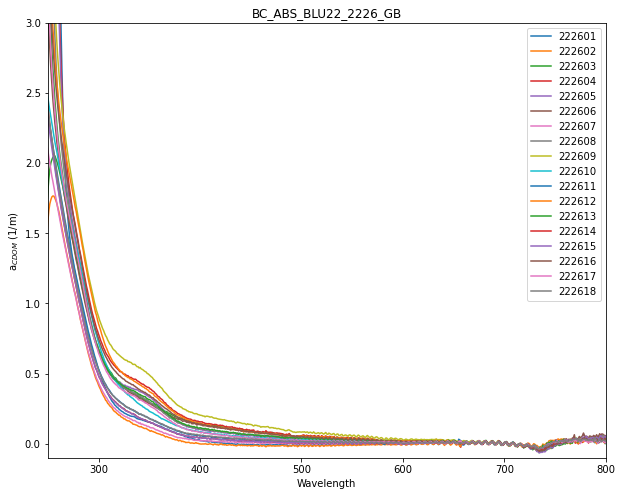

In [281]:
#HERE, WE MAKE A QUICK AND DIRTY GRAPH OF THE DATA TO SAVE AND CHECK WORK 
fig, ax = plt.subplots(figsize=(10,8))
df.plot(label='', ax=ax)
ax.set_ylim(-.1,3)
ax.set_xlim(250,800)
ax.set_xlabel("Wavelength")
ax.set_ylabel("a$_{CDOM}$ (1/m)")
ax.set_title("BC_ABS_BLU22_2226_GB")
#plt.savefig("../outputs/BC_ABS_BLU22_2226_GB_plot.png")

In [282]:
#get the values for the key wavelths we want and the baslline correction 
abs_254 = df[65:66].mean(axis=0)
abs_280 = df[91:92].mean(axis=0)
abs_320 = df[131:132].mean(axis=0)
abs_412 = df[223:224].mean(axis=0)
abs_444 = df[255:256].mean(axis=0)

In [283]:
#MAKE THE NEW OUTPUTS TABEL 

df2 = pd.concat([bcorr, abs_254, abs_280, abs_320, abs_412, abs_444], axis=1) 
df2 = df2.rename(columns={0: 'baseline_correction_pchip', 1: 'abs_254',
                         2: 'abs_280', 3: 'abs_320', 4: 'abs_412',
                         5: 'abs_444'})
df2

,baseline_correction_pchip,abs_254,abs_280,abs_320,abs_412,abs_444
222601,-1.088454e-18,8.604168,1.124844,0.248171,0.011264,-0.004047
222602,-1.530638e-19,1.759575,0.959536,0.203674,-0.003958,-0.012686
222603,-6.394667e-18,2.024383,1.255049,0.439133,0.128328,0.095812
222604,1.142877e-17,7.112708,1.441119,0.524499,0.138843,0.099119
222605,-2.449021e-18,6.870058,1.351457,0.440324,0.091099,0.061601
222606,2.721135e-18,2.560235,1.241001,0.426365,0.121040,0.088543
222607,-6.802837e-20,1.906373,0.960452,0.225673,0.018982,0.009738
222608,1.360567e-19,3.632023,1.323785,0.426606,0.095377,0.069328
222609,-8.163405e-19,3.687315,1.609619,0.633898,0.189957,0.144392
222610,-3.809589e-18,2.284028,1.349131,0.420467,0.069635,0.046650


I need an output table for each sampling event with the sample number
corresponding parameters = abs 254, abs 280, abs 320, abs 412, abs 444, the spectral slope of 275 to 295, the spectral slope of 350 to 400, the spectral slope of 275 to 700, and the baseline correction we used, aka average of 700 to 750 nm. 

In [353]:
#NEW FUNTION FOR GETTING THE CURVE FIT TO WORK 
#see above for the breakdown of diff parts 
def GET_CDOM_FOR_OUTS(name):
    df = pd.read_csv(name, skiprows=14, sep='\t', names=['wl', 'abs'], )
    df['abs'] = df['abs']*(2.303/X)
    return df

In [354]:
#MAKE IT ALL IN ONE EASY TO USE DATA FRAME 
#this makes a new data frame there all the columns are the scanns and the rows are the wavelths 
frames = []
for f in files:
    df = GET_CDOM_FOR_OUTS(f) # runs the processing function 
    ID = f.split("/")[5][21:-4] #takes junk out of the file name to make a single ID 
    df = df.rename(columns={'abs': ID}) # renames the abs col to the new id 
    df = df.set_index('wl', drop=True) # makes the wl the new index, aka the rows 
    frames.append(df) # adds the new col from each scan to a part of frames 
    
df = pd.concat(frames, axis=1, ignore_index=False) # adds all the things in the frame together to make a new df 
df

,222601_Absorbance__0__00,222601_Absorbance__1__01,222602_Absorbance__0__02,222603_Absorbance__0__03,222604_Absorbance__0__04,222605_Absorbance__0__05,222606_Absorbance__0__06,222607_Absorbance__0__07,222607_Absorbance__0__08,222607_Absorbance__1__09,...,222616_Absorbance__2__40,222616_Absorbance__3__41,222616_Absorbance__4__42,222616_Absorbance__5__43,222617_Absorbance__0__44,222617_Absorbance__1__45,222617_Absorbance__2__46,222618_Absorbance__0__47,222618_Absorbance__1__48,222618_Absorbance__2__49
wl,,,,,,,,,,,,,,,,,,,,,
189.2794,-0.000000,-0.629550,-0.000000,-0.000000,-4.074139,-5.726825,-6.655104,-0.000000,-0.000000,-0.000000,...,-0.000000,8.314396,2.697058,3.126039,0.604066,-0.000000,-3.750870,-2.978326,-2.101016,-3.200604
189.6618,-0.000000,-0.629550,-0.000000,-0.000000,-4.074139,-5.726825,-6.655104,-0.000000,-0.000000,-0.000000,...,-0.000000,8.314396,2.697058,3.126039,0.604066,-0.000000,-3.750870,-2.978326,-2.101016,-3.200604
190.0441,-0.000000,-0.629550,-0.000000,-0.000000,-4.074139,-5.726825,-6.655104,-0.000000,-0.000000,-0.000000,...,-0.000000,8.314396,2.697058,3.126039,0.604066,-0.000000,-3.750870,-2.978326,-2.101016,-3.200604
190.4264,-4.060925,-0.764992,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-7.976497,...,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-5.176559,-0.000000,-0.000000,-0.000000,-0.000000
190.8087,-0.000000,-1.730553,-0.000000,-0.000000,-0.000000,-5.260562,-6.486154,-0.660225,-0.031619,-0.000000,...,-0.000000,2.637124,1.956134,3.550301,-0.514872,-1.456836,-2.354912,-2.847603,0.867872,-3.568234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
880.5978,0.440307,0.326573,-0.124117,1.067497,0.315247,0.583301,1.567267,0.126476,0.100048,0.230300,...,0.567727,0.781982,0.137802,0.383204,0.017933,-0.080699,0.091082,0.275605,0.258144,0.501186
880.8884,0.445970,-0.077868,0.271358,1.049564,0.617751,1.164714,1.752734,-0.220390,-0.143937,-0.131195,...,0.415767,0.902323,0.560176,0.562536,0.231716,0.259087,0.511096,0.327045,0.123173,0.418599
881.1790,0.390755,0.130252,0.249649,1.233143,0.506377,0.956123,2.118005,0.187827,0.161871,0.034923,...,0.421430,0.713552,0.548850,0.587076,-0.281740,-0.053328,-0.131667,0.304392,-0.015102,0.141578


In [355]:
#HERE WE ARE GOING TO AVERAGE THE SCANNS TO GET A VALUE FOR EACH WAVELENTH
#this filters eveything by all that have the work 'Absorbance' with anything after it 
#and turns it into a new object 
d = df.filter(regex='Absorbance*', axis=1)
#this splits the column names by 
names = d.columns.str.rsplit('_', n=5).str[0]
#this part groups evethign by the sample ID that we have in names then avarages all scanns regardless of how many there are 
df = d.groupby(names, axis=1).mean()
df

,222601,222602,222603,222604,222605,222606,222607,222608,222609,222610,222611,222612,222613,222614,222615,222616,222617,222618
wl,,,,,,,,,,,,,,,,,,
189.2794,-0.314775,0.000000,0.000000,-4.074139,-5.726825,-6.655104,0.000000,0.000000,0.000000,-0.515029,0.000000,0.000000,-0.376440,-0.070868,0.000000,2.356249,-1.048935,-2.759982
189.6618,-0.314775,0.000000,0.000000,-4.074139,-5.726825,-6.655104,0.000000,0.000000,0.000000,-0.515029,0.000000,0.000000,-0.376440,-0.070868,0.000000,2.356249,-1.048935,-2.759982
190.0441,-0.314775,0.000000,0.000000,-4.074139,-5.726825,-6.655104,0.000000,0.000000,0.000000,-0.515029,0.000000,0.000000,-0.376440,-0.070868,0.000000,2.356249,-1.048935,-2.759982
190.4264,-2.412959,0.000000,0.000000,0.000000,0.000000,0.000000,-1.994124,0.000000,0.000000,0.524625,0.000000,0.792521,0.000000,1.284819,-0.292752,0.000000,-1.725520,0.000000
190.8087,-0.865277,0.000000,0.000000,0.000000,-5.260562,-6.486154,-0.172961,0.000000,0.000000,-2.281921,-1.262560,-4.727128,0.000000,0.741553,0.031147,1.357260,-1.442207,-1.849322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
880.5978,0.383440,-0.124117,1.067497,0.315247,0.583301,1.567267,0.141696,0.367631,1.064036,0.305336,0.320753,0.449431,0.423003,0.326652,0.318708,0.536737,0.009439,0.344978
880.8884,0.184051,0.271358,1.049564,0.617751,1.164714,1.752734,-0.145471,0.151331,0.700968,0.456353,0.248548,0.588020,0.296370,0.341203,0.382260,0.632774,0.333966,0.289605
881.1790,0.260503,0.249649,1.233143,0.506377,0.956123,2.118005,0.150309,0.496938,1.200738,0.549794,0.459971,0.616178,0.371878,0.278358,0.344034,0.555850,-0.155578,0.143623


In [356]:
#bcorr2 = df[486:537].mean(axis=0) # 486:537 is 675 to 725 nm and this line takes the average 
#df = df[:] - df[486:537].mean(axis=0) # here we correct the data by that average 
#bcorr2
bcorr2 = df[(df['wl']>=675) & (df['wl']<=725)]['abs'].mean()

KeyError: 'wl'

Text(0.5, 1.0, 'BC_ABS_BLU22_2226_GB')

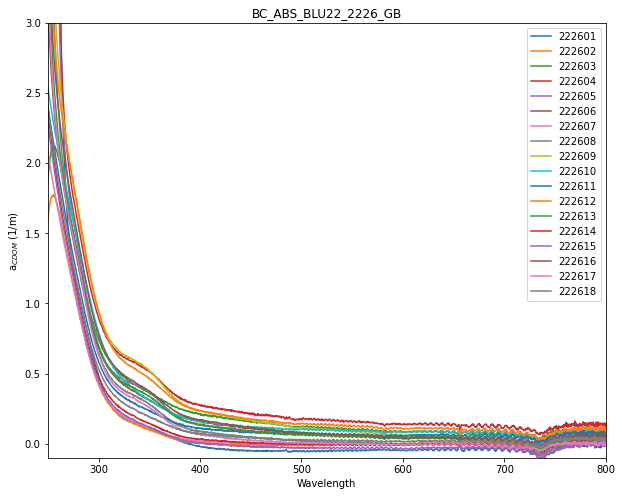

In [357]:
#HERE, WE MAKE A QUICK AND DIRTY GRAPH OF THE DATA TO SAVE AND CHECK WORK 
fig, ax = plt.subplots(figsize=(10,8))
df.plot(label='', ax=ax)
ax.set_ylim(-.1,3)
ax.set_xlim(250,800)
ax.set_xlabel("Wavelength")
ax.set_ylabel("a$_{CDOM}$ (1/m)")
ax.set_title("BC_ABS_BLU22_2226_GB")
#plt.savefig("../outputs/BC_ABS_BLU22_2226_GB_plot.png")

In [358]:
df.reset_index(inplace=True)
df = df.rename(columns = {'index':'wl'})
df

,wl,222601,222602,222603,222604,222605,222606,222607,222608,222609,222610,222611,222612,222613,222614,222615,222616,222617,222618
0,189.2794,-0.314775,0.000000,0.000000,-4.074139,-5.726825,-6.655104,0.000000,0.000000,0.000000,-0.515029,0.000000,0.000000,-0.376440,-0.070868,0.000000,2.356249,-1.048935,-2.759982
1,189.6618,-0.314775,0.000000,0.000000,-4.074139,-5.726825,-6.655104,0.000000,0.000000,0.000000,-0.515029,0.000000,0.000000,-0.376440,-0.070868,0.000000,2.356249,-1.048935,-2.759982
2,190.0441,-0.314775,0.000000,0.000000,-4.074139,-5.726825,-6.655104,0.000000,0.000000,0.000000,-0.515029,0.000000,0.000000,-0.376440,-0.070868,0.000000,2.356249,-1.048935,-2.759982
3,190.4264,-2.412959,0.000000,0.000000,0.000000,0.000000,0.000000,-1.994124,0.000000,0.000000,0.524625,0.000000,0.792521,0.000000,1.284819,-0.292752,0.000000,-1.725520,0.000000
4,190.8087,-0.865277,0.000000,0.000000,0.000000,-5.260562,-6.486154,-0.172961,0.000000,0.000000,-2.281921,-1.262560,-4.727128,0.000000,0.741553,0.031147,1.357260,-1.442207,-1.849322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2043,880.5978,0.383440,-0.124117,1.067497,0.315247,0.583301,1.567267,0.141696,0.367631,1.064036,0.305336,0.320753,0.449431,0.423003,0.326652,0.318708,0.536737,0.009439,0.344978
2044,880.8884,0.184051,0.271358,1.049564,0.617751,1.164714,1.752734,-0.145471,0.151331,0.700968,0.456353,0.248548,0.588020,0.296370,0.341203,0.382260,0.632774,0.333966,0.289605
2045,881.1790,0.260503,0.249649,1.233143,0.506377,0.956123,2.118005,0.150309,0.496938,1.200738,0.549794,0.459971,0.616178,0.371878,0.278358,0.344034,0.555850,-0.155578,0.143623
2046,881.4695,0.260503,0.249649,1.233143,0.506377,0.956123,2.118005,0.150309,0.496938,1.200738,0.549794,0.459971,0.616178,0.371878,0.278358,0.344034,0.555850,-0.155578,0.143623


there are two ways we are going to calculate the spectral slopes 
1. Single exponential (SEM) where: A(g)=Ae^slope
2. Hyperbolic (HM) where: A(g)=A((wl)/(532))^slope


In [406]:
def decay(t, N, tau):
    return N*np.exp(-t/tau)

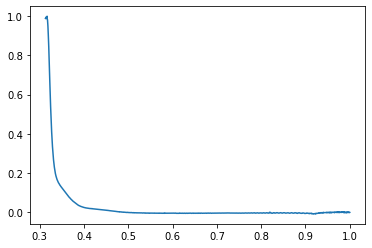

In [407]:
#t = df['wl']
y = df[(df['wl']>=250) & (df['wl']<=800)]['222601']
#y = df['222602']
t = df[(df['wl']>=250) & (df['wl']<=800)]['wl']
y = np.array(y)
t = np.array(t)
maxy = max(y)
maxt = max(t)

y=y/maxy
t=t/maxt
plt.plot(t,y)

parameter names: ['N', 'tau']
[[Model]]
    Model(decay)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 3
    # data points      = 1612
    # variables        = 2
    chi-square         = 0.59344042
    reduced chi-square = 3.6860e-04
    Akaike info crit   = -12742.1636
    Bayesian info crit = -12731.3931
[[Variables]]
    N:    1.0539e+09 +/- 1.7743e+08 (16.84%) (init = 1.053886e+09)
    tau:  0.01518014 +/- 1.2110e-04 (0.80%) (init = 0.01518014)
[[Correlations]] (unreported correlations are < 0.100)
    C(N, tau) = -1.000
{'N': 1053886438.0496712, 'tau': 0.015180135728341307}


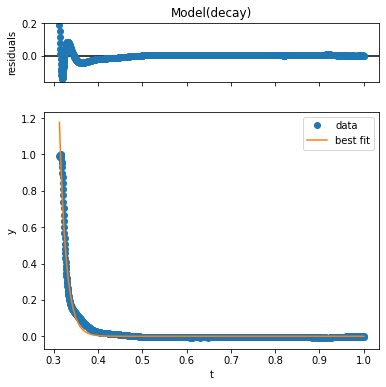

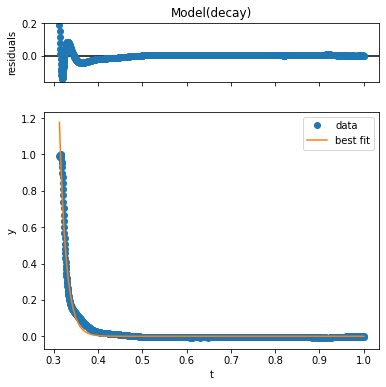

In [408]:
model = Model(decay, independent_vars=['t'])
result = model.fit(y, t=t, N=1053886438.0496712, tau=0.015180135728341307)

print(f'parameter names: {model.param_names}')
print(result.fit_report())
print(result.values)
result.plot()


In [425]:
c = 300/maxt
y = decay(c, 1053886438, 0.015180135728341307)
yabs = y*maxy
print(yabs)

0.17147567704350947


In [246]:

# numpy.linspace with the given arguments
# produce an array of 40 numbers between 0
# and 10, both inclusive


# y is another array which stores 3.45 times
# the sine of (values in x) * 1.334.
# The random.normal() draws random sample
# from normal (Gaussian) distribution to make
# them scatter across the base line

# Test function with coefficients as parameters
def test(x, a, b):
    return a * np.exp(b * x)

# curve_fit() function takes the test-function
# x-data and y-data as argument and returns
# the coefficients a and b in param and
# the estimated covariance of param in param_cov
param, param_cov = curve_fit(test, x, y)


print("Sine function coefficients:")
print(param)
print("Covariance of coefficients:")
print(param_cov)

# ans stores the new y-data according to
# the coefficients given by curve-fit() function
ans = (param[0](np.sin(param[1]x)))

'''Below 4 lines can be un-commented for plotting results
using matplotlib as shown in the first example. '''

# plt.plot(x, y, 'o', color ='red', label ="data")
# plt.plot(x, ans, '--', color ='blue', label ="optimized data")
# plt.legend()
# plt.show()

SyntaxError: invalid syntax. Perhaps you forgot a comma? (3762742923.py, line 30)

In [192]:
print(result.values)

{'N': 3.0, 'tau': 1.0}


In [319]:
#EXPONENTAL REGRESSION A(g)=Ae^slope
def exp_equation(x, a, s, b):
    return a * np.exp(s * x) + b

In [322]:
#df[86:512] is 275 to 700
#df[86:107] is 275 to 295
#df[161:212] is 350 to 400
#xdata = df['wl'][86:512]
#xdata = np.array(xdata, dtype=float)
#ydata = df['222602'][86:512]
#ydata = np.array(ydata, dtype=float)

ydata = df[(df['wl']>=250) & (df['wl']<=800)]['222601']
xdata = df[(df['wl']>=250) & (df['wl']<=800)]['wl']

params, cv = curve_fit(exp_equation, xdata, ydata)
a, s, b = params
#squaredDiffs = np.square(ydata - exp_equation(xdata, a, s, b))
#squaredDiffsFromMean = np.square(ydata - np.mean(ydata))
#rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
#print(f"R² = {rSquared}")
print(f"A = {a}")
print(f"b = {b}")
print(f"spectral slope = {s}")

A = 1.0
b = 1.0
spectral slope = 1.0


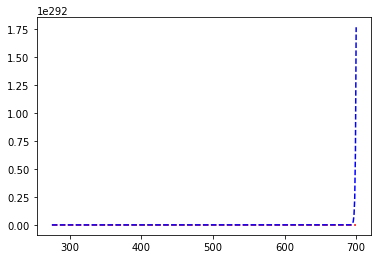

In [253]:
xdata = df['wl'][86:512]
ydata = df['222602'][86:512]
plt.plot(xdata, ydata, '--', color='red', label="data")
plt.plot(xdata, exp_equation(xdata, a, s, b), '--', color='blue', label="fitted")

In [90]:
#HYPERBOLIC REGRESSION  A(g)=A((wl)/(532))^slope
def hyp_equation(x, a, w, s, b):
    return a * ((w)/(532)) * np.exp(-s) + b

In [91]:
#df[86:512] is 275 to 700
#df[86:107] is 275 to 295
#df[161:212] is 350 to 400
xdata = df['wl'][86:512]
xdata = np.array(xdata, dtype=float)
ydata = df['222602'][86:512]
ydata = np.array(ydata, dtype=float)

params, cv = curve_fit(hyp_equation, xdata, ydata)
a, w, s, b = params
squaredDiffs = np.square(ydata - hyp_equation(xdata, a, w, s, b))
squaredDiffsFromMean = np.square(ydata - np.mean(ydata))
rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
print(f"R² = {rSquared}")
print(f"A = {a}")
print(f"b = {b}")
print(f"w = {w}")
print(f"spectral slope = {s}")

R² = -2.220446049250313e-16
A = -206.88511453585957
b = 0.06823241563507265
w = -206.88511453585963
spectral slope = 208.8851145358596


ValueError: x and y must have same first dimension, but have shapes (426,) and (1,)

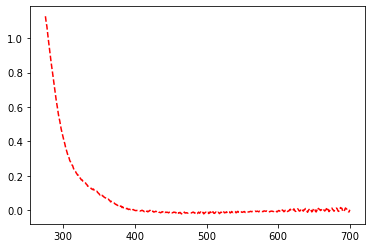

In [93]:
xdata = df['wl'][86:512]
ydata = df['222602'][86:512]
plt.plot(xdata, ydata, '--', color='red', label="data")
plt.plot(xdata, hyp_equation(xdata, a, w, s, b), '--', color='blue', label="fitted")